# ALMA figures of B5-IRS1 observations

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import aplpy
from astropy.io import fits
import sys
sys.path.append('..')
from B5setup import *
import numpy as np
from spectral_cube import SpectralCube
from astropy.wcs import WCS
import os
import matplotlib.ticker as mticker
from matplotlib.patches import Circle, Ellipse
from scipy import stats
import velocity_tools.stream_lines as SL
from astropy.coordinates import SkyCoord, FK5
from astropy.modeling.functional_models import Gaussian1D
import pyregion
import regions

In [3]:
def get_spectra(cube, position, velstart, velend):
    '''
    Extracts the spectra (velocity, intensity) given a cube.
    
    Returns the spectra of the cube given, in the native units of the cube. 
    
    Args:
        cube (SpectralCube): datacube 
        position (NDarray): array size 2 containing ra and dec
        velstart (astropy.units): initial velocity of the spectra in u.km/u.s
        velend (astropy.units): final velocity of the spectra in u.km/u.s
    '''
    cubenew = cube.spectral_slab(velstart, velend)
    cubehead = cubenew.header
    bmaj = cubehead['bmaj'] * u.deg
    bmin = cubehead['bmin'] * u.deg
    beamarea = (1.133 * bmaj * bmin).to(u.arcsec**2)
    if 'restfreq' in cubehead._keyword_indices:
        restfreq = cubehead['restfreq'] * u.Hz
    else:
        restfreq = cubehead['restfrq'] * u.Hz
    cubewcs = WCS(cubehead)
    ra, dec = cubewcs.celestial.all_world2pix(position[0], position[1], 0)
#     rah = degtohoursRA(position[0])
#     dech = degtohoursDEC(position[1])
    velocities = cubenew.spectral_axis
    intensities = cubenew[:, int(dec), int(ra)]
    return velocities, intensities

def getPositionFromRegions(regionfile):
    regionload = regions.read_ds9(regionfile)
    positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value] for i in range(len(regionload))]
    regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]
    return positions, regionlabels

def get_parameters_spectra(paramcube, position, header):
    '''
    This function returns all the contents in the cube along the spectra. 
    This means it returns errors as well if the paramscube includes them
    
    Args:
        paramcube (ndarray): cube with the parameters and errors for each parameter
        position (NDarray): array size 2 containing ra and dec in degrees
        header (SpectralCube.header): header to transform the wcs into pixel positions
    '''
    cubewcs = WCS(header)
    ra, dec = cubewcs.celestial.all_world2pix(position[0], position[1], 0)
    params = paramcube[:, int(dec), int(ra)]
    return params


# H2CO

## First look: moments

In [4]:
h2cocubefile = 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_pbcor.fits'
h2cocubefileK = 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_pbcor_K.fits'
h2comom0file = 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_mom0.fits'
h2comom0bluefile = 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_mom0_blueenv.fits'
h2comom1file = 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_mom1.fits'
rms_mom0 = 0.005714 # Jy/b km/s
figurefolder = 'figures/'
freq_H2CO = 218.222195 * u.GHz

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


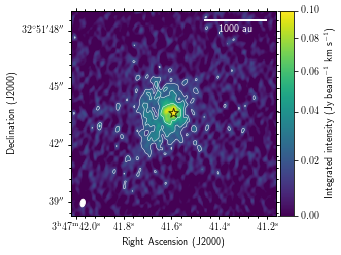

In [56]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_cut_mom0_wcontour_3510sigma.pdf'
gc = plot_aplpy_subfig(h2comom0file, fig, (1,1,1), 'arcsinh', 0, 0.1, 'viridis', vmid=0.05, label_col='w',barsize=1000)
gc.show_contour(h2comom0file, colors='w', levels=rms_mom0*np.array([3,5,10]), linewidths=0.5)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')
# gc.show_contour('../B5_wide_multiple/mask_C2.fits', colors='w', linewidths=1)
# gc.show_contour('../B5_wide_multiple/mask_C3.fits', colors='w', linewidths=1)


if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


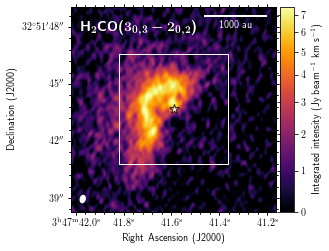

In [16]:
# moment 0 with inferno for streamer gallery
savefigure = True
title = r'\textbf{H\boldmath$_2$CO($3_{0,3}-2_{0,2}$)}'
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_cut_mom0_blueenv_inferno_wzoom.pdf'
gc = plot_aplpy_subfig(h2comom0bluefile, fig, (1,1,1), 'arcsinh', 0, 7.5, 'inferno', vmid=3, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='w', edgecolor='k', s=100)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_H2CO)/2).to(u.deg).value, color='w')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.add_label(0.62,0.9, title, color='w',
              relative=True, horizontalalignment='right', 
              size=14)
gc.show_rectangles(ra_yso, dec_yso, width=0.0016, height=0.0016, facecolor='none', edgecolor='w')
# arrowlength = 0.0005
# pa = (157.1-180) * 180/ np.pi
# gc.show_arrows(ra_yso+0.0001, dec_yso+0.00005,arrowlength*np.sin(pa), arrowlength*np.cos(pa), color='w', zorder=100, linewidth=3)
# gc.show_arrows(ra_yso+0.0001, dec_yso+0.00005,arrowlength*np.sin(pa), arrowlength*np.cos(pa), color='b', zorder=100)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.00005, -arrowlength*np.sin(pa), -arrowlength*np.cos(pa), color='w', linewidth=3)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.00005, -arrowlength*np.sin(pa), -arrowlength*np.cos(pa), color='r', zorder=100)

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


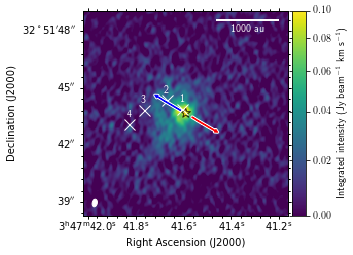

In [4]:
# moment 0 with regions and outflow
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_cut_mom0_regions_woutflow.pdf' #_regions
positionfile = figurefolder + 'region_plot_H2CO_2.reg'
gc = plot_aplpy_subfig(h2comom0file, fig, (1,1,1), 'arcsinh', 0, 0.1, 'viridis', vmid=0.05, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_H2CO)/2).to(u.deg).value, color='w')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.show_regions(positionfile)


arrowlength = 0.0005
pa = (157.1-180) * 180/ np.pi

gc.show_arrows(ra_yso+0.0001, dec_yso+0.00005,arrowlength*np.sin(pa), arrowlength*np.cos(pa), color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.00005,arrowlength*np.sin(pa), arrowlength*np.cos(pa), color='b', zorder=100)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.00005, -arrowlength*np.sin(pa), -arrowlength*np.cos(pa), color='w', linewidth=3)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.00005, -arrowlength*np.sin(pa), -arrowlength*np.cos(pa), color='r', zorder=100)

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


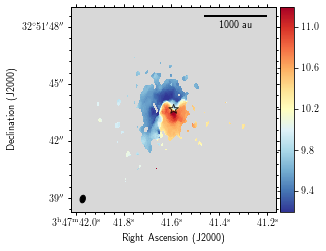

In [9]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_cut_mom1_3sigmacut.pdf'

mom1data = fits.getdata(h2comom1file)
mom0data = fits.getdata(h2comom0file)
mom1data[np.where(mom0data<=rms_mom0*3)] = np.nan
mom1header = fits.getheader(h2comom1file)

gc = plot_aplpy_subfig(fits.PrimaryHDU(mom1data, mom1header), fig, (1,1,1), 'linear', 10.2-1,10.2+1, 'RdYlBu_r', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.colorbar.set_ticks([9.4,9.8,10.2,10.6,11])
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

## Channel maps of H2CO

In [10]:
# here we load the cube
if not os.path.exists(h2cocubefileK):
    cube_H2CO = SpectralCube.read(h2cocubefile).with_spectral_unit(u.km/u.s)
    cube_H2CO.allow_huge_operations=True
    cube_H2CO = cube_H2CO.to(u.K)
    cube_H2CO.hdu.writeto(h2cocubefileK)
else:
    cube_H2CO = SpectralCube.read(h2cocubefileK).with_spectral_unit(u.km/u.s)
wcssky = WCS(cube_H2CO.header).celestial    
ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)
pbradius = (primary_beam_alma(freq_H2CO)/2).to(u.deg).value / cube_H2CO.header['CDELT2']

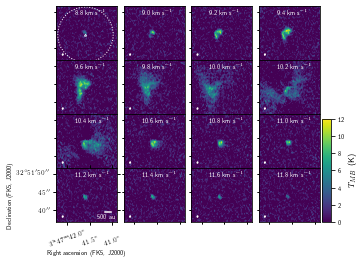

In [11]:
savefigure = True

velinit = 8.8 * u.km/u.s
deltav = 0.2 * u.km/u.s
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 4
ncols = 4
vmax = 12
vmin = 0
velocity_array = cube_H2CO.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 
bmaj, bmin = np.array([cube_H2CO.header['BMAJ'], cube_H2CO.header['BMIN']])/np.abs(cube_H2CO.header['CDELT2'])
bpa = cube_H2CO.header['BPA']-90
scalebarsize = 500
scalebarpix = int((scalebarsize / dist_B5.value) / 3600 / cube_H2CO.header['CDELT2'])


fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_H2CO.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.3, 0.85), xycoords='axes fraction', color='w', size=6)
    beam = Ellipse((32, 29), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
    ax.add_patch(beam)
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    
    if i == 0:
        pb = Circle((ra_yso_pix, dec_yso_pix), pbradius, ec = 'w', fc='None', ls=':')
        ax.add_patch(pb)
        ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)    
        
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        # ax.set_xlabel('Right ascension (FK5, J2000)')
        # ax.set_ylabel('Declination (FK5, J2000)')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)
        lat.set_ticklabel(size=6)
        ax.plot([250, 250+scalebarpix], [50, 50], color='w', lw=1.5)
        ax.annotate(str(scalebarsize)+' au', (0.66, 0.07), xycoords='axes fraction', color='w', size=6)
        
fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.5)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.36])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,2,4,6,8,10,12])
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.set_yticklabels(['0', '2', '4', '6', '8', '10', '12'])
cbar_ax.tick_params(labelsize=6)
# fig.subplots_adjust(hspace = 0, wspace=-0.5) 

if savefigure:
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    

## Spectra of selected regions

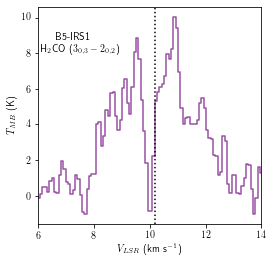

In [12]:
#spectra at the location of the protostar
savefig = True
colorHC3N = '#984ea3'
positionfile = figurefolder +'B5_IRS1.reg'
# positions, labels = getPositionFromRegions(positionfile)
position = [ra_yso, dec_yso]
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'B5-IRS1 \\ H$_2$CO ($3_{0,3} - 2_{0,2}$)'
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_H2CO, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N)
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

        Use `regions.Regions.read` instead. [warnings]


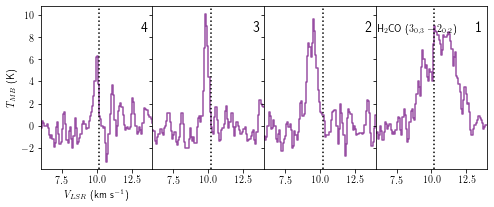

In [13]:
#spectra at selected locations in the streamer and pseudodisk
savefig = True
color = '#984ea3'
positionfile = figurefolder + 'region_plot_H2CO.reg'
positions, labels = getPositionFromRegions(positionfile)
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'H$_2$CO ($3_{0,3} - 2_{0,2}$)'
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_spectra_selected_regions.pdf'

fig, axes = plt.subplots(ncols=4, nrows=1, sharex=True, sharey=True, figsize=(8,3))
axes[0].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axes[0].set_ylabel(r'$T_{MB}$ (K)')

for i in reversed(range(len(axes))):
    position = positions[i]
    spectrum = get_spectra(cube_H2CO, position, velinit, velend)
    ax = axes[-(i-3)]
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=color)
    ax.text(0.9, 0.85, labels[i], horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
fig.subplots_adjust(wspace=0)
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
if savefig:
    fig.savefig(figname, bbox_inches='tight')

## Gaussian fits results: components (multiple)

### Results of the 1, 2 and 3 component fits

In [1]:
# Filenames: resulting components of 1, 2, and 3 Gaussian fit, both masked and not masked combined
h2cofitfile1G = 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
h2cofitfile2G = 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_2G_fitparams_total_aicres.fits'
h2cofitfile3G = 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_3G_fitparams_total_aicres.fits'
h2cofitparamsmissing = 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_paramsmissing.fits'
h2concomponentfile = 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'

h2cofitfile1G_allchans = 'gaussfit_H2CO/all_chans/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_2_filtered_Vlsr'

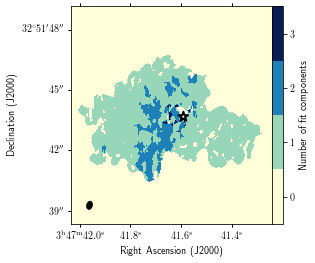

In [15]:
# plot the number of components 

savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_total_aicres_ncomponents.pdf'

data = fits.getdata(h2concomponentfile)
data[np.where(np.isnan(data))] = 0
header = fits.getheader(h2concomponentfile)
wcs = WCS(header)
bmaj, bmin = np.array([header['BMAJ'], header['BMIN']])/np.abs(header['CDELT2'])
bpa = header['BPA']-90

cmap1 = plt.cm.get_cmap("YlGnBu", 4).copy()
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data, cmap=cmap1, vmin=-0.5, vmax=3.5) # red
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4), pad=0)
beam = Ellipse((62, 49), bmaj, bmin, angle=bpa, ec = 'k', fc='k')
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k', linewidth=2)
ax.add_patch(beam)
ax.set_xlim([45,230])
ax.set_ylim([32,232])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

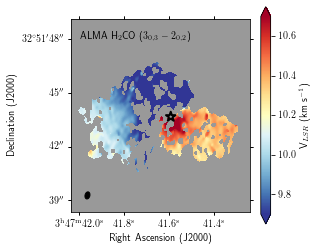

In [36]:
# plot the components of the filtered 1G fit 

savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_1G_fitparams_total_aicres_Vlsr'

cube = fits.getdata(h2cofitfile1G)
paramscube = cube[1]
header = fits.getheader(h2cofitparamsmissing)
stretch = 'linear'
vmin = 10.2-0.5
vmax = 10.2+0.5
cmap = 'RdYlBu_r'
quantities = r'V$_{LSR}$ (km s$^{-1}$)'

data = paramscube
# header = fits.getheader(h2concomponentfile)
wcs = WCS(header)
bmaj, bmin = np.array([header['BMAJ'], header['BMIN']])/np.abs(header['CDELT2'])
bpa = header['BPA']-90

cmap1 = plt.cm.get_cmap(cmap).copy()
cmap1.set_bad(color='0.6')
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data, cmap=cmap1, vmin=vmin, vmax=vmax) # red
cax = plt.colorbar(sc1, ax=ax, label=quantities,extend='both')
beam = Ellipse((62, 49), bmaj, bmin, angle=bpa, ec = 'k', fc='k')
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k', linewidth=2)
ax.add_patch(beam)
ax.set_xlim([45,230])
ax.set_ylim([32,232])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')
ax.annotate(r'ALMA H$_2$CO ($3_{0,3}-2_{0,2}$)', (0.05, 0.9), xycoords='axes fraction',color='k', size=10)

if savefigure:
    fig.savefig(figname+'.pdf', bbox_inches='tight', dpi=300)
    

### Blueshifted and redshifted envelope with streamline models


In [ ]:
h2cotpeakbluefile = 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_Tpeak.fits'
h2cotpeakredfile = 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_Tpeak.fits'
h2coblueparamsfile ='gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope.fits'
h2cobluevlsrfile ='gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_vlsr.fits'
h2coredparamsfile ='gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope.fits'
h2coredvlsrfile ='gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_vlsr.fits'
spine_coordinates_file = 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_spine_coords_vel.npy'
kde_blue_file = 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_kde.npy'
kde_blue_sigma_file = 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_kde_sigma_nt.npy'
kde_red_file = 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_kde.npy'
kde_red_sigma_file = 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_kde_sigma_nt.npy'
sl_model_init_result_file = 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_sl_model_res.npy'
sl_model_red_init_result_file = 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_sl_model_res.npy'


# spine_coords_ra, spine_coords_dec, deltar_proj, spine_vel = np.load(spine_coordinates_file)
fil0_ra, fil0_dec, dsky0, velo0 = np.load(sl_model_init_result_file)
xx, yy, zz = np.load(kde_blue_file)
xx_sigma, yy_sigma, zz_sigma = np.load(kde_blue_sigma_file)

fil0_ra_red, fil0_dec_red, dsky0_red, velo0_red = np.load(sl_model_red_init_result_file)
xx_sigma_red, yy_sigma_red, zz_sigma_red = np.load(kde_red_sigma_file)
xx_red, yy_red, zz_red = np.load(kde_red_file)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


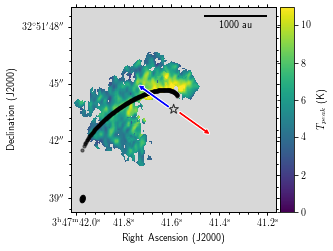

In [6]:
# plot of the tpeak with an outflow contour and the 
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_blueshifted_env_woutflow_wmodel.pdf'
savefigure = True

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h2cotpeakbluefile, fig, (1,1,1), 'linear', 0, 11, 'viridis', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.colorbar.set_axis_label_text(r'$T_{peak}$ (K)')
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='b', zorder=100)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='w', linewidth=3)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='r', zorder=100)
# gc.show_markers(spine_coords_ra, spine_coords_dec, marker='.', alpha=0.5, facecolor='b', edgecolor=None, s=80)
gc.show_markers(fil0_ra, fil0_dec, marker='.', alpha=0.5, facecolor='k', edgecolor=None, s=40)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


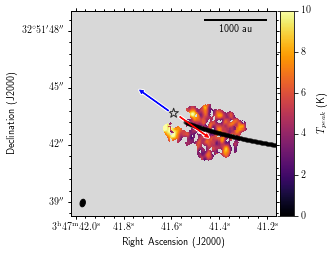

In [7]:
# plot of the tpeak with an outflow contour for the redshifted component
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_woutflow_wmodel.pdf'
savefigure = True

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h2cotpeakredfile, fig, (1,1,1), 'linear', 0, 10, 'inferno', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.colorbar.set_axis_label_text(r'$T_{peak}$ (K)')
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='b', zorder=100)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='w', linewidth=3)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='r', zorder=100)

gc.show_markers(fil0_ra_red, fil0_dec_red, marker='.', alpha=0.5, facecolor='k', edgecolor=None, s=40)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

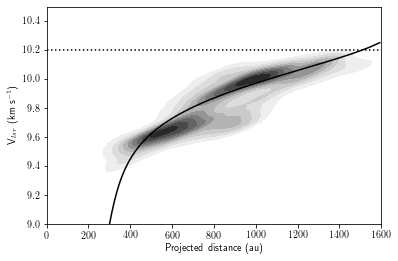

In [8]:
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_blueshifted_env_kde_wslmodel.pdf'
savefigure = True
velmin, velmax = 9, 10.5
xmin, xmax = 0, 1600
velobject = 10.2

fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(velobject, color='k', ls=':')
ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])
# ax2.plot(deltar_proj, spine_vel, 'b.')
ax2.plot(dsky0, velo0, 'k-')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

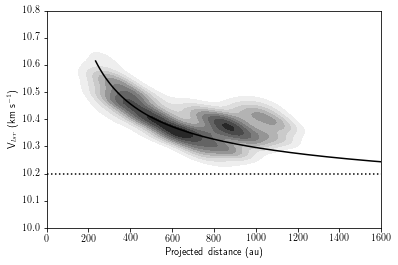

In [9]:
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_kde_wslmodel.pdf'
savefigure = True
velmin, velmax = 10, 10.8
xmin, xmax = 0, 1600
velobject = 10.2

fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx_red, yy_red, zz_red, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(velobject, color='k', ls=':')
ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])
ax2.plot(dsky0_red, velo0_red, 'k-')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

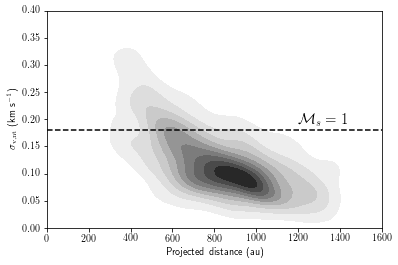

In [24]:
# we need to check the kde of the sigma_v
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_blueshifted_env_kde_sigma.pdf'
savefigure = False
vmin, vmax = 0, 0.4
xmin, xmax = 0, 1600
soundspeed = 0.18

fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"$\sigma_{\mathrm{v, nt}}$ (km s$^{-1}$)")
ax2.contourf(xx_sigma, yy_sigma, zz_sigma, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(soundspeed, color='k', linestyle='dashed')
# ax2.annotate(r'$c_{s}=0.18$ km s$^{-1}$', (0.65, 0.48), xycoords='axes fraction', size=15)
ax2.annotate(r'$\mathcal{M}_{s}=1$', (0.75, 0.48), xycoords='axes fraction', size=15)
ax2.set_ylim([vmin,vmax])
ax2.set_xlim([xmin,xmax])
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

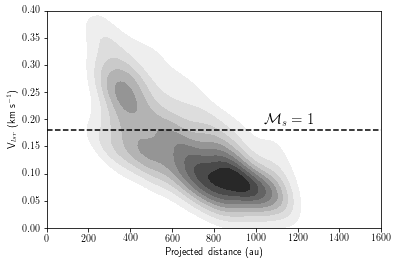

In [25]:
# we also check the kde of the sigma_v for the redshifted side
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_kde_sigma.pdf'
savefigure = False
vmin, vmax = 0, 0.4
xmin, xmax = 0, 1600
soundspeed = 0.18

fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx_sigma_red, yy_sigma_red, zz_sigma_red, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(soundspeed, color='k', linestyle='dashed')
ax2.annotate(r'$\mathcal{M}_{s}=1$', (0.65, 0.48), xycoords='axes fraction', size=15)
ax2.set_ylim([vmin,vmax])
ax2.set_xlim([xmin,xmax])
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

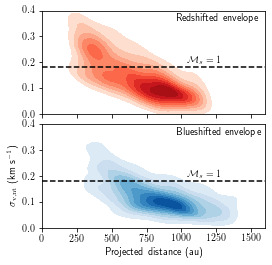

In [26]:
# plot of  the kde of the sigma_v for the blue and red envelopes together

figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_envelopes_kde_sigma.pdf'
savefigure = True
vmin, vmax = 0, 0.4
xmin, xmax = 0, 1600
soundspeed = 0.18

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(4,4))

axes[0].contourf(xx_sigma_red, yy_sigma_red, zz_sigma_red, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
axes[1].contourf(xx_sigma, yy_sigma, zz_sigma, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
axes[0].axhline(soundspeed, color='k', linestyle='dashed')
axes[1].axhline(soundspeed, color='k', linestyle='dashed')
axes[0].annotate(r'$\mathcal{M}_{s}=1$', (0.65, 0.5), xycoords='axes fraction', size=10)
axes[0].annotate('Redshifted envelope', (0.6, 0.9), xycoords='axes fraction', size=10)
axes[1].annotate(r'$\mathcal{M}_{s}=1$', (0.65, 0.5), xycoords='axes fraction', size=10)
axes[1].annotate('Blueshifted envelope', (0.6, 0.9), xycoords='axes fraction', size=10)
axes[0].set_ylim([vmin,vmax])
axes[0].set_xlim([xmin,xmax])

axes[1].set_xlabel('Projected distance (au)')
axes[1].set_ylabel(r"$\sigma_{\mathrm{v, nt}}$ (km s$^{-1}$)")
plt.subplots_adjust(hspace=0.1)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/tmp/ipykernel_32211/1314718327.py:19: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlGnBu_r").copy()
  cmap3.set_bad('0.85', 1.)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/ho

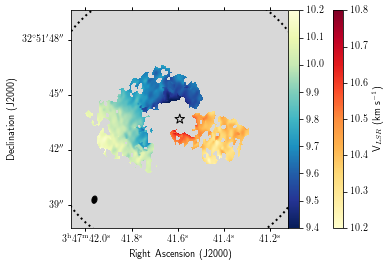

In [65]:
# test to plot the v_lsr together
fig.clf()
savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_envelopes_vlsr.pdf'

data1 = fits.getdata(h2coredvlsrfile)
header1 = fits.getheader(h2coredvlsrfile)
data2 = fits.getdata(h2cobluevlsrfile)
wcs = WCS(header1)
bmaj, bmin = np.array([header1['BMAJ'], header1['BMIN']])/np.abs(header1['CDELT2'])
bpa = header1['BPA']-90
pbradius = (primary_beam_alma(freq_H2CO)/2).to(u.deg).value / header1['CDELT2']

cmap1 = plt.cm.get_cmap("YlOrRd").copy()
cmap1.set_bad('white', 0.)
cmap2 = plt.cm.get_cmap("YlGnBu_r").copy()
cmap2.set_bad('white', 0.)
cmap3 = plt.cm.YlGnBu_r
cmap3.set_bad('0.85', 1.)
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data1, vmin=10.2, vmax=10.2+0.6, cmap=cmap1, zorder=10) # red
sc2 = ax.imshow(data2, vmin=10.2-0.8, vmax=10.2, cmap=cmap2, zorder=10) # blue
ax.imshow(np.ones(np.shape(data1))*np.nan, cmap=cmap3, zorder=0)
plt.colorbar(sc1, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', pad=0.005)
plt.colorbar(sc2, ax=ax, pad=0)
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k')
beam = Ellipse((62, 49), bmaj, bmin, angle=bpa, ec = 'k', fc='k')
pb = Circle((rapix, decpix), pbradius, ec = 'k', fc='None', ls=':', lw=2)
ax.add_patch(pb)
ax.add_patch(beam)
ax.set_xlim([rapix-110,rapix+110])
ax.set_ylim([decpix-110,decpix+110])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')

if savefigure:
    fig.savefig(figname, dpi=300,bbox_inches='tight')

We also did a test using all free parameters for the red streamer, which gave centrifugal radius of around 5-6 au, which we do not use as final, but we do include it in our discussion

In [28]:
sl_tinymodel_red_init_result_file = 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_sl_tinymodel_res.npy'
fil0_ra_tinyred, fil0_dec_tinyred, dsky0_tinyred, velo0_tinyred = np.load(sl_tinymodel_red_init_result_file)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


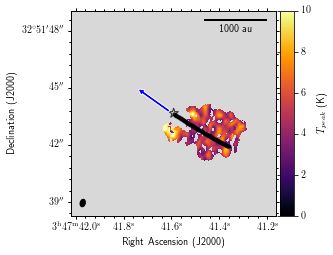

In [29]:
# plot of the tpeak with an outflow contour for the redshifted component and tiny parameters
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_woutflow_wtinymodel.pdf'
savefigure = True

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h2cotpeakredfile, fig, (1,1,1), 'linear', 0, 10, 'inferno', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.colorbar.set_axis_label_text(r'$T_{peak}$ (K)')
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='b', zorder=100)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='w', linewidth=3)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='r', zorder=100)

gc.show_markers(fil0_ra_tinyred, fil0_dec_tinyred, marker='.', alpha=0.5, facecolor='k', edgecolor=None, s=40)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

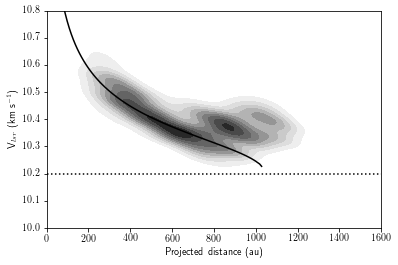

In [30]:
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_kde_wsltinymodel.pdf'
savefigure = True
velmin, velmax = 10, 10.8
xmin, xmax = 0, 1600
velobject = 10.2

fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx_red, yy_red, zz_red, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(velobject, color='k', ls=':')
ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])
ax2.plot(dsky0_tinyred, velo0_tinyred, 'k-')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

# C18O

## Moments

In [36]:
c18ocubefile = 'cleaned_images/B5IRS1_C18O_robust05_multi.fits'
c18ocubefileK = 'cleaned_images/B5IRS1_C18O_robust05_multi_K.fits'
c18omom0file = 'cleaned_images/B5IRS1_C18O_robust05_multi_mom0.fits'
c18omom1file = 'cleaned_images/B5IRS1_C18O_robust05_multi_mom1.fits'
rms_mom0_c18o = 0.007 # Jy/b km/s
figurefolder = 'figures/'
freq_C18O = 219.560354 * u.GHz

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


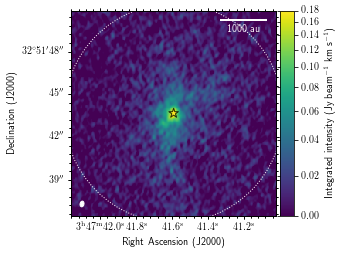

In [37]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_mom0.pdf'
gc = plot_aplpy_subfig(c18omom0file, fig, (1,1,1), 'arcsinh', 0, 0.18, 'viridis', vmid=0.05, label_col='w',barsize=1000)

# gc.show_contour(c18omom0file, colors='w', levels=rms_mom0_c18o*np.array([3,5,10]), linewidths=0.5)
gc.recenter(ra_yso, dec_yso, 0.002)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_C18O)/2).to(u.deg).value, color='w', ls=':')
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
# gc.show_contour('gaussfit_H2CO/B5IRS1_H2COa_robust05_multi_3_cut_pbcor_K_mask.fits', levels=[1], colors='w', linestyles='--')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')


if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


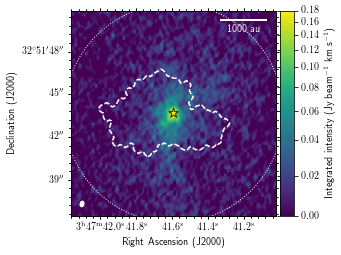

In [38]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_mom0_wH2COarea.pdf'
gc = plot_aplpy_subfig(c18omom0file, fig, (1,1,1), 'arcsinh', 0, 0.18, 'viridis', vmid=0.05, label_col='w',barsize=1000)

# gc.show_contour(c18omom0file, colors='w', levels=rms_mom0_c18o*np.array([3,5,10]), linewidths=0.5)
gc.recenter(ra_yso, dec_yso, 0.002)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_C18O)/2).to(u.deg).value, color='w', ls=':')
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.show_contour('gaussfit_H2CO/B5IRS1_H2COa_robust05_multi_3_cut_pbcor_K_mask.fits', levels=[1], colors='w', linestyles='--')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')


if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


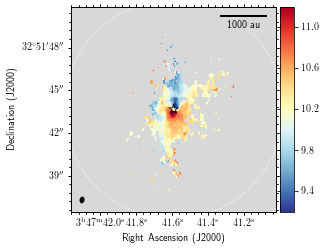

In [39]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_mom1_3sigmacut.pdf'

mom1data = fits.getdata(c18omom1file)
mom0data = fits.getdata(c18omom0file)
mom1data[np.where(mom0data<=rms_mom0_c18o*3)] = np.nan
mom1header = fits.getheader(c18omom1file)

gc = plot_aplpy_subfig(fits.PrimaryHDU(mom1data, mom1header), fig, (1,1,1), 'linear', 10.2-1,10.2+1, 'RdYlBu_r', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.002)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_C18O)/2).to(u.deg).value, color='w', ls=':')

gc.colorbar.set_ticks([9.4,9.8,10.2,10.6,11])
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

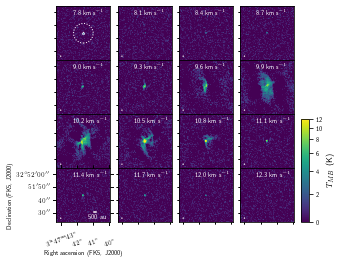

In [40]:
# C18O channel maps
from astropy.visualization import simple_norm

if not os.path.exists(c18ocubefileK):
    cube_C18O = SpectralCube.read(h2cocubefile).with_spectral_unit(u.km/u.s)
    cube_C18O.allow_huge_operations=True
    cube_C18O = cube_H2CO.to(u.K)
    cube_C18O.hdu.writeto(c18ocubefileK)
else:
    cube_C18O = SpectralCube.read(c18ocubefileK).with_spectral_unit(u.km/u.s)
    
wcssky = WCS(cube_C18O.header).celestial
ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)
pbradius = (primary_beam_alma(freq_C18O)/2).to(u.deg).value / cube_C18O.header['CDELT2']
velinit = 7.8 * u.km / u.s
deltav = 0.3 * u.km / u.s
nrows = 4
ncols = 4
vmin = 0
vmax = 12
xmin = 150
xmax = 610
ymin = 150 
ymax = 610
bmaj, bmin = np.array([cube_C18O.header['BMAJ'], cube_C18O.header['BMIN']])/np.abs(cube_C18O.header['CDELT2'])
bpa = cube_C18O.header['BPA']-90
scalebarsize = 500
scalebarpix = int((scalebarsize / dist_B5.value) / 3600 / cube_C18O.header['CDELT2'])

velocity_array = cube_C18O.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 

savefigure = True
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)

fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_C18O.unmasked_data[indexvel, :, :]
    norm = simple_norm(planevel, 'asinh', min_cut = vmin, max_cut=vmax, asinh_a=0.3)
    im = ax.imshow(planevel, norm=norm)#vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.3, 0.85), xycoords='axes fraction', color='w', size=6)
    beam = Ellipse((62, 59), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
    ax.add_patch(beam)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    if i == 0:
        pb = Circle((ra_yso_pix, dec_yso_pix), pbradius, ec = 'w', fc='None', ls=':')
        ax.add_patch(pb)
        ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=10, linewidth=0.5)
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        # ax.set_xlabel('Right ascension (FK5, J2000)')
        # ax.set_ylabel('Declination (FK5, J2000)')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)
        lat.set_ticklabel(size=6)
        ax.plot([550, 550+scalebarpix], [150, 150], color='w', lw=1.5)
        ax.annotate(str(scalebarsize)+' au', (0.58, 0.07), xycoords='axes fraction', color='w', size=6)
fig.tight_layout(pad=-1)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.6)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.36])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 2, 4, 6, 8, 10, 12], label=r'$T_{MB}$ (K)')
cbar_ax.set_yticklabels(['0', '2', '4', '6', '8', '10', '12'])
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)

if savefigure:
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    

## Selected spectra

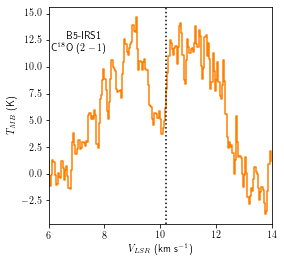

In [41]:
#spectra at the location of the protostar
savefig = False
colorC18O = '#ff7f00'
# positionfile = figurefolder +'B5_IRS1.reg'
# positions, labels = getPositionFromRegions(positionfile)
position = [ra_yso, dec_yso]
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'B5-IRS1 \\ C$^{18}$O ($2-1$)'
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_C18O, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorC18O)
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

        Use `regions.Regions.read` instead. [warnings]


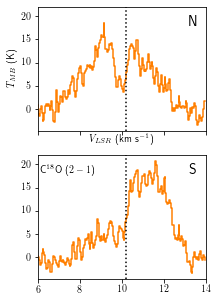

In [42]:
#spectra at selected locations in the possible gas disk
savefig = True
positionfile = figurefolder + 'region_plot_C18O.reg'
positions, labels = getPositionFromRegions(positionfile)
positions.reverse()
labels.reverse()
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'C$^{18}$O ($2-1$)'
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_spectra_selected_regions.pdf'

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(3,5))
axes[0].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axes[0].set_ylabel(r'$T_{MB}$ (K)')

for i in reversed(range(len(axes))):
    position = positions[i]
    spectrum = get_spectra(cube_C18O, position, velinit, velend)
    ax = axes[-(i-1)]
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorC18O)
    ax.text(0.9, 0.85, labels[i], horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
fig.subplots_adjust(wspace=0)
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
if savefig:
    fig.savefig(figname, bbox_inches='tight')

# SO$_2$ (From Sakai et al.)

In [43]:
so2cubefile = '2017.1.01462.S_Sakai_Higherres/B5IRS1_spw29_pbcor_SO2_14_014_13_113_K_contcorrected.fits'
so2mom0file = '2017.1.01462.S_Sakai_Higherres/B5IRS1_spw29_pbcor_SO2_14_014_13_113_K_contcorrected_8.5_12.1.fits'
so2cube = SpectralCube.read(so2cubefile).with_spectral_unit(u.km/u.s)

## General images of SO$_2$

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


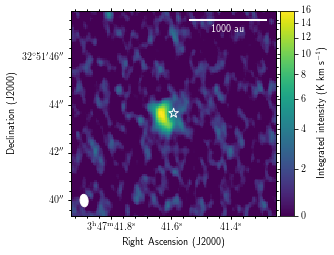

In [44]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_SO2_mom0.pdf'
gc = plot_aplpy_subfig(so2mom0file, fig, (1,1,1), 'arcsinh', 0, 16, 'viridis', vmid=4, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0012)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=1, layer='lay_yso',  facecolor='None', edgecolor='w', s=100)
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Channel maps of SO$_2$

/tmp/ipykernel_32211/553069630.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=0)


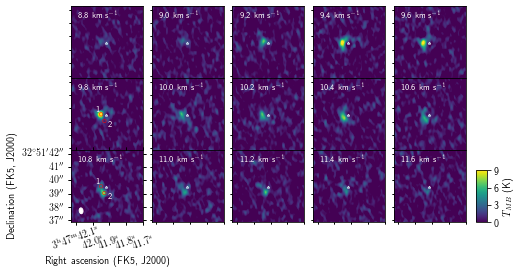

In [45]:
savefigure = True

wcsskyso2 = WCS(so2cube.header).celestial    
ra_yso_pix, dec_yso_pix = wcsskyso2.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)
bmaj, bmin = np.array([so2cube.header['BMAJ'], so2cube.header['BMIN']])/np.abs(so2cube.header['CDELT2'])
bpa = so2cube.header['BPA']-90

velinit = 8.8 * u.km/u.s
deltav = 0.2 * u.km/u.s
figname = figurefolder + 'B5IRS1_SO2_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 3
ncols = 5
vmax = 9
vmin = 0
velocity_array = so2cube.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 

fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = so2cube.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.1, 0.85), xycoords='axes fraction', color='w', size=8)
    ax.set_xlim([316-50, 316+50])
    ax.set_ylim([316-50, 316+50])
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)   
    if np.round(velocity_sample[i], 2) == 9.8 or np.round(velocity_sample[i], 2) == 10.8:
        ax.scatter(307.8, 316, marker='o', facecolor='none', edgecolor='r', s=12, linewidth=0.5) # peak 1
        ax.text(301, 320, '1', c='w', size=8)
        ax.scatter(312.34056, 306.65427, marker='o', facecolor='none', edgecolor='r', s=12, linewidth=0.5) # peak2
        ax.text(317, 300, '2', c='w', size=8)
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        # ax.set_xlabel('Right ascension (FK5, J2000)')
        # ax.set_ylabel('Declination (FK5, J2000)')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=10)
        lat.set_axislabel('Declination (FK5, J2000)', size=10)
        lon.set_ticklabel(rotation=20,pad=15,ha='right')
        beam = Ellipse((280, 282), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
        ax.add_patch(beam)
fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.9)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.18])
fig.colorbar(im, cax=cbar_ax, label=r'$T_{MB}$ (K)', ticks=[0, 3, 6, 9])
cbar_ax.set_yticklabels(['0', '3', '6', '9'])
fig.subplots_adjust(hspace = -0, wspace=0) 

if savefigure:
    fig.savefig(figname, bbox_inches='tight')
    

## Selected spectra and comparison with H$_2$CO

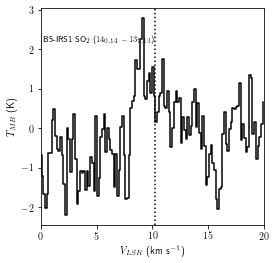

In [46]:
# spectra at the location of the protostar
savefig = True

position = ra_yso, dec_yso
velinitspec = 0 * u.km / u.s
velendspec = 20 * u.km / u.s

label = r'B5-IRS1 SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position, velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

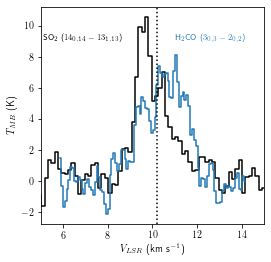

In [47]:
# spectra at the peak of SO2 emission
savefig = True

position = 56.9234836*u.deg, 32.8621240*u.deg
velinitspec = 5 * u.km / u.s
velendspec = 15 * u.km / u.s

label = r'SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_peak1_wH2CO.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position, velinitspec, velendspec)
spectrum_H2CO = get_spectra(cube_H2CO, position, velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.plot(spectrum_H2CO[0], spectrum_H2CO[1], drawstyle='steps-mid', color='C0')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.text(0.6, 0.85, r'H$_{2}$CO ($3_{0, 3}- 2_{0,2}$)', horizontalalignment='left', transform=ax.transAxes, color='C0', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

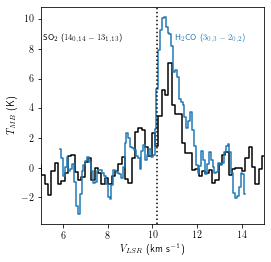

In [48]:
# spectra at the second peak of SO2 emission
savefig = True

position = 56.9233867*u.deg, 32.8619561*u.deg
velinitspec = 5 * u.km / u.s
velendspec = 15 * u.km / u.s

label = r'SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_peak2.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position, velinitspec, velendspec)
spectrum_H2CO = get_spectra(cube_H2CO, position, velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.plot(spectrum_H2CO[0], spectrum_H2CO[1], drawstyle='steps-mid', color='C0')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.text(0.6, 0.85, r'H$_{2}$CO ($3_{0, 3}- 2_{0,2}$)', horizontalalignment='left', transform=ax.transAxes, color='C0', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

In [49]:
so2cube.header['BMAJ'] / cube_H2CO.header['BMAJ']

1.2994392590444444

# H$^{13}$CO$^+$ (from van't Hoff et al. 2022)

## Asymmetric structures in moment 0 and velocity

In [50]:
h13copmom0file = '2017.1.01371.S_Hoff/B5-IRS1_H13COp_2_1_short_cut_K_mom0blue.fits'
figurefolder = 'figures/'
h13copvlsrfile = '2017.1.01371.S_Hoff/B5-IRS1_H13COp_2_1_short_cut_K_kms_1G_fitparams_2_filtered_Vlsr.fits'
diffvlsrfile = 'gaussfit_H2CO/analysis_central_chans_masked/B5_H2CO_blueshifted_envelope_minus_H13COp'

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


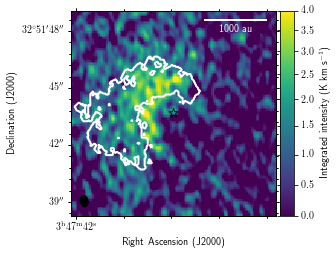

In [51]:
savefigure=True
figname = figurefolder + 'H13CO_mom0_wH2COcontour.pdf'

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h13copmom0file, fig, (1,1,1), 'arcsinh', 0, 4.000, 'viridis', label_col='k', vmid=3.000, barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.scalebar.set_color('w')
gc.colorbar.set_axis_label_text('Integrated intensity (K km s$^{-1}$)')
footprint_h2co_blue = np.isfinite(fits.getdata(h2cotpeakbluefile)).astype(int)
gc.show_contour(fits.PrimaryHDU(footprint_h2co_blue, fits.getheader(h2cotpeakbluefile)), colors='w', levels=[0.5], linewidths=2)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


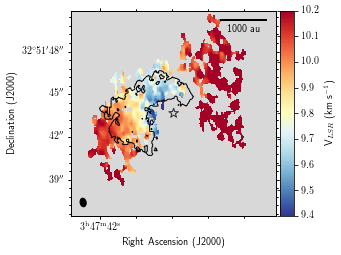

In [52]:
savefigure = True
figname = figurefolder + 'H13CO_1G_fitparams_2_filtered_Vlsr.pdf'

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h13copvlsrfile, fig, (1,1,1), 'linear', 10.2-0.8, 10.2, 'RdYlBu_r', label_col='k', barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.002)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
footprint_h2co_blue = np.isfinite(fits.getdata(h2cotpeakbluefile)).astype(int)
gc.show_contour(fits.PrimaryHDU(footprint_h2co_blue, fits.getheader(h2cotpeakbluefile)), colors='k', levels=[0.5], linewidths=1)
gc.colorbar.set_axis_label_text('V$_{LSR}$ (km s$^{-1}$)')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

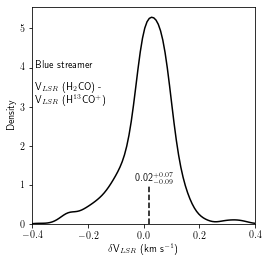

In [53]:
savefigure = True
figname = figurefolder + 'components_blueshifted_envelope_diff_wr_H13COp.pdf'

data, dens, vlsr_median_unc = np.load(diffvlsrfile+'.npy', allow_pickle=True)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(data, dens, color='k')
ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0, 1], color='k', ls='--')
ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10)
ax.set_xlabel(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel('Density')
ax.set_xlim([-0.4, 0.4])
ax.set_ylim(bottom=0)
ax.text(-0.39, 4, 'Blue streamer ', size=10)
ax.text(-0.39, 3.1, 'V$_{LSR}$ (H$_2$CO) -\n V$_{LSR}$ (H$^{13}$CO$^+$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

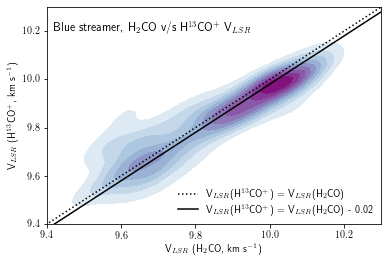

In [54]:
savefigure = True
figname = figurefolder + 'components_blueshifted_envelope_vlsr_comparison_H13COp.pdf'

xx, yy, zz = np.load(diffvlsrfile+'_2DKDE.npy')
def shifted_line(velx, shift):
    return velx + shift

linesample = np.linspace(9.2, 10.6, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='BuPu', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.plot(linesample, linesample, 'k:', label='V$_{LSR}$(H$^{13}$CO$^+$) = V$_{LSR}$(H$_2$CO)')
ax.plot(linesample, shifted_line(linesample, -0.02), 'k-', label='V$_{LSR}$(H$^{13}$CO$^+$) = V$_{LSR}$(H$_2$CO) - 0.02')
ax.set_xlabel('V$_{LSR}$ (H$_2$CO, km s$^{-1}$)')
ax.set_ylabel('V$_{LSR}$ (H$^{13}$CO$^+$, km s$^{-1}$)')
ax.text(9.42, 10.2, 'Blue streamer, H$_2$CO v/s H$^{13}$CO$^+$ V$_{LSR}$', size=12)
ax.set_xlim([9.4, 10.3])
ax.set_ylim([9.4, 10.3])
ax.legend(frameon=False, loc=4)

if savefigure:
    fig.savefig(figname, bbox_inches='tight')